# Classifying real vs. AI-generated images

In this notebook we aim to classify real and AI-generated synethetic images, provided by the [CIFAKE](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images) data set [1]. CIFAKE contains 60,000 real images from the CIFAR-10 data set [2], and 60,000 fake images generated using Stable Diffusion [1]. The data set is divided into 100,000 training images and 20,000 testing images [1].

We will be using [fastai](https://www.fast.ai/) built on top of [PyTorch](https://pytorch.org/) to build a model for the classification task.

In [3]:
from fastai.vision.all import *

# Ensure GPU acceleration is available
torch.cuda.is_available()

True

In [4]:
# The following is a temporary patch to fix a bug with VS Code displaying
# progress bars for Jupyter notebooks
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Step 1: Loading the CIFAKE dataset

We create a `DataBlock` to load training images from the dataset into our model. We specify a 20% validation split, which should be randomly selected. For consistency between runs of the notebook, we also seed the random process to get the same random validation split each time.

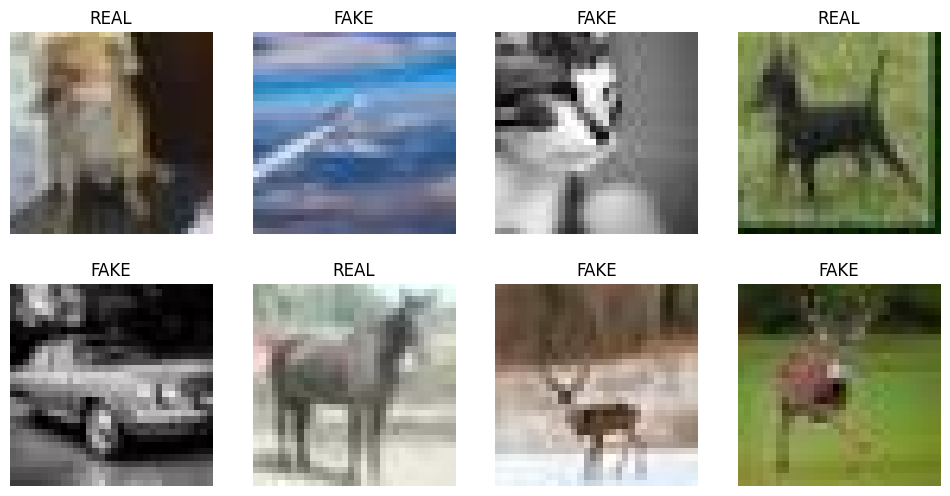

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
).dataloaders(Path('..', 'data', 'cifake', 'train'))

dls.show_batch(max_n=8)

## Step 2: Training the models

### Benchmark: PCA and logistic regression

To enable a comparison with the deep neural networks that we'll shortly be testing, we'll construct a benchmark by finding the principal components of the training data and fitting a logisitic regression model. We're expecting reasonably poor performace; if a technique as simple as logistic regression happens to perform well, then there's really no justification for using something as complex as deep neural networks.

We start by separately loading the training and testing images (X), and assigning labels (y) to these.

In [1]:
from cv2 import imread

def load_images(filepath):
    return [imread(str(img_fp)) for img_fp in get_image_files(filepath)]

X_train = load_images(Path('..', 'data', 'cifake', 'train'))
y_train = np.array([0] * 50000 + [1] * 50000)

X_test = load_images(Path('..', 'data', 'cifake', 'test'))
y_test = np.array([0] * 10000 + [1] * 10000)

PCA requires each data sample to be represented as a single feature vector. To convert our 3-channel images into a single dimension, we flatten them. That is, the rows of each channel are concatenated end-to-end, and the channels are similarly flattened.

In [8]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

X_train_flat = flatten_images(X_train)
X_test_flat  = flatten_images(X_test)

Now we find the principal components of the training images and use these to transform both the training and testing data. We can then fit a logistic regression model to the training data, and use it to predict labels for the testing data. Comparing the predicted labels with the true labels gives us our logsitic regression accuracy.

We'll repeat this several times using an increasing number of principal components to fit logistic regression model.

In [16]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

for N in (2, 5, 10, 20, 50, 100):

    pca = PCA(n_components=N)
    pca.fit(X_train_flat)

    X_train_pca = pca.transform(X_train_flat)
    X_test_pca  = pca.transform(X_test_flat)

    clf = LogisticRegression(random_state=0).fit(X_train_pca, y_train)
    print(f'Test accuracy ({N=}): {clf.score(X_test_pca, y_test) * 100:.2f}%')

Test accuracy (N=2): 59.46%
Test accuracy (N=5): 60.30%
Test accuracy (N=10): 62.12%
Test accuracy (N=20): 62.73%
Test accuracy (N=50): 64.99%
Test accuracy (N=100): 66.40%


We have now got our benchmark accuracy. As expected, the performance of the logistic regression model is rather poor. Even using the top 100 principal components, only a 66.40% accuracy is achieved, which is just 16.40% better than guessing at random.

Also observe that by nature of PCA returning the highest variance-explaining components first, increasing the number of components has diminishing returns. Therefore, further increasing the number of components further probably won't be worth the additional computation.

### ResNet-18

Onto the first deep neural network! We're using the ResNet-18 model with pre-trained weights provided by PyTorch. More information can be found on the PyTorch documentation page: [PyTorch | RESNET18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html). The weights are described as closely reproducing the results of the original paper, which achieved 72.12% accuracy on ImageNet [3].

Loading the model using fastai:

In [18]:
learn_resnet18 = vision_learner(dls, resnet18, metrics=error_rate)

Before fine-tuning, we'll define a callback to help us optimise the training process. As the model is fine-tuned, its validation loss decreases as it becomes better at the classification task. However, if the model is trained too much, it will overfit the training data and lose generalisation ability. The validation loss will then start to increase again.

To avoid both stopping too early and overfitting, we'll define a callback to stop fine-tuning if the validation loss does not decrease for two consecutive epochs. Furthermore, we'll define another callback to continuously save the best result. This lets us avoid having to train the model again to the desired number of epochs.

In [22]:
callbacks = [
    EarlyStoppingCallback(monitor='valid_loss', patience=2),
    SaveModelCallback(monitor='valid_loss', fname='resnet18-cifake-opt')
]

Now we can go ahead and fine-tune the model. The training will stop either when the `EarlyStoppingCallback` triggers, or after 10 epochs.

In [23]:
learn_resnet18.fine_tune(10, cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.005894,0.184031,0.035950,02:00
1,0.007774,0.180611,0.037850,02:02
2,0.019731,0.140901,0.036450,02:03
3,0.015798,0.137724,0.036450,02:05
4,0.012413,0.138610,0.036100,02:03
5,0.007229,0.152936,0.037450,02:03


The model is now trained. We can see the fine-tuning process stopped early after not improving on the validation loss for two consecutive epochs. On training completion, `SaveModelCallback` automatically loads the state of the model after the epoch with the lowest validation loss. For the above example, this occurs after epoch 3. Therefore, the final model has an error rate of 0.036450, representing a validation accuracy of 96.36%.

### ResNet-34

Now onto the second model! As with ResNet-18, we're using the ResNet-34 model with pre-trained weights provided by PyTorch. More information can be found on the PyTorch documentation page: [PyTorch | RESNET34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html). The weights are described as closely reproducing the results of the original paper, which achieved 74.97% accuracy on ImageNet [3].

Load the model using fastai:

In [25]:
learn_resnet34 = vision_learner(dls, resnet34, metrics=error_rate)

We'll redefine the callbacks, because the previous `SaveModelCallback` specifies a filepath to save the ResNet-18 model, which we don't want to override.

In [30]:
callbacks = [
    EarlyStoppingCallback(monitor='valid_loss', patience=2),
    SaveModelCallback(monitor='valid_loss', fname='resnet34-cifake-opt')
]

Now, we fine-tune the model. This follows the same tune as training ResNet-18.

In [31]:
learn_resnet34.fine_tune(10, cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.183066,0.153732,0.061000,02:24
1,0.149897,0.122686,0.048100,02:24
2,0.108766,0.105786,0.039600,02:24
3,0.075364,0.106475,0.037750,02:25
4,0.050223,0.104542,0.036100,02:24
5,0.036618,0.114074,0.034650,02:23
6,0.012831,0.127419,0.032250,02:24


Again, the fine-tuning process stopped early after not improving on the validation loss for two consecutive epochs. The loaded state of the model is from after epoch 4. The error rate is 0.036100, representing a validation accuracy of 96.39%. While this is only marginally higher than ResNet-18, we see that the validation loss is quite a bit lower -- 0.104542 compared to 0.137724 for ResNet-18. This may or may not translate into a better test result for ResNet-34.

### ViT-B/16

Finally, the last and biggest model. Once again, we're using the ViT-B/16 model with pre-trained weights provided by PyTorch. More information can be found on the PyTorch documentation page: [PyTorch | VIT_B_16](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16). The weights are from fine-tuning of the original model weights on the ImageNet dataset. While PyTorch does not provide an accuracy number, the original paper reports an 88.55% accuracy on ImageNet [4].

## Step 3: Testing the models

In [49]:
test_path = Path('..', 'data', 'cifake', 'test')
test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)
_, preds, labels = learn.get_preds(dl=test_dl, with_decoded=True)

preds, labels = preds.numpy(), labels.numpy()

In [50]:
correct = sum(preds == labels)
total = len(labels)
acc = 100 * sum(preds == labels) / len(labels)

print(f'Test accuracy: {acc:.2f}% ({correct}/{total})')

Test accuracy: 96.48% (19296/20000)


Let's plot a confusion matrix to visualise the proportions of misclassifications.

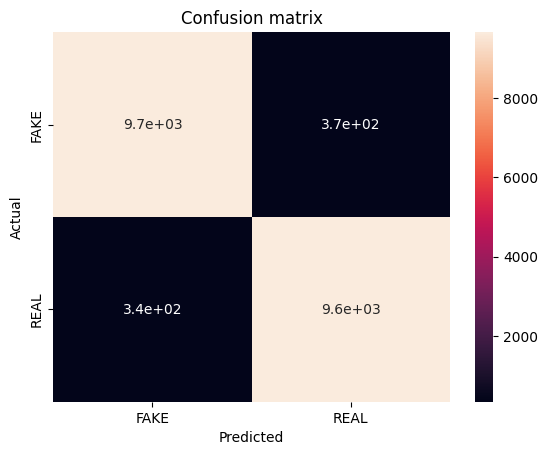

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion = confusion_matrix(labels, preds)
sns.heatmap(confusion, annot=True, xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])

plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Step 4: Visualise the classification

In [46]:
# Reload the learner before cutting so this cell can be re-run without issue
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.load('resnet18-cifake-6epoch')

# Cut the model right before the classification layer
new_head = cut_model(learn.model[-1], 2)
learn.model[-1] = new_head
learn.model.cuda()

# Run data through the new network to derive the feature vectors
x, y = dls.one_batch()
feature_vectors = learn.model(x)

c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fastai.data.core.DataLoaders

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(feature_vectors.cpu().detach().numpy())

Text(0.5, 1.0, 't-SNE model visualisation')

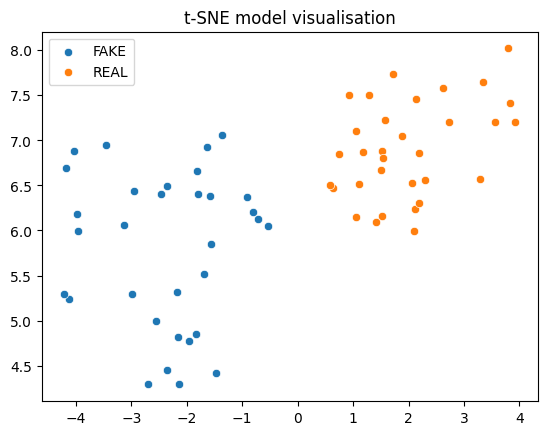

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = y.cpu().numpy()

_, ax = plt.subplots()

sns.scatterplot(x=tsne[:, 0][labels == 0], y=tsne[:, 1][labels == 0], label='FAKE', ax=ax)
sns.scatterplot(x=tsne[:, 0][labels == 1], y=tsne[:, 1][labels == 1], label='REAL', ax=ax)

ax.set_title('t-SNE model visualisation')

## References

[1] J. J. Bird and A. Lotfi, “Cifake: Image classification and explainable identification of
ai-generated synthetic images,” 2023. arXiv: 2303.14126 [cs.CV].

[2] A. Krizhevsky, G. Hinton, *et al.*, “Learning multiple layers of features from tiny images,”
2009.

[3] K. He, X. Zhang, S. Ren, and J. Sun, "Deep residual learning for image recognition," in *Proc. IEEE Conf. Comput. Vision Pattern Recogit.*, 2016, pp. 770-778.

[4] A. Dosovitskiy, L. Beyer, A. Kolesnikov, *et al.*, “An image is worth 16x16 words: Trans-
formers for image recognition at scale,” 2021. arXiv: 2010.11929 [cs.CV].